In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Normalization, Activation
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
data = pd.read_csv("data/preprocessed.csv")
m = len(data)
test, cv, train = data.iloc[:round(0.02*m)], data.iloc[round(0.02*m): round(0.102*m)], data.iloc[round(0.102*m):]
x_cols = data.columns.drop(["winner"])
X_test, y_test = test[test["winner"] != 0.5][x_cols].values, test[test["winner"] != 0.5]["winner"].values
X_cv, y_cv = cv[cv["winner"] != 0.5][x_cols].values, cv[cv["winner"] != 0.5]["winner"].values
X_train, y_train = train[x_cols].values, train["winner"].values

In [3]:
scaler = Normalization(axis= -1)
scaler.adapt(X_train)

2025-08-03 00:07:01.764668: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        scaler,
        Dense(units = 64, activation="relu", kernel_regularizer=L2(l2= 1)),
        Dense(units = 1)
    ]
)


In [5]:
model.compile(
    loss= BinaryCrossentropy(from_logits= True),
    optimizer= Adam()
)
history= model.fit(
    X_train, y_train,
    validation_data= (X_cv, y_cv),
    epochs = 500,
    verbose= 1,
    callbacks= [
        tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)
    ]
)

Epoch 1/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 47.9750 - val_loss: 5.0081
Epoch 2/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.9443 - val_loss: 0.7773
Epoch 3/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7072 - val_loss: 0.6886
Epoch 4/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6707 - val_loss: 0.6873
Epoch 5/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6703 - val_loss: 0.6900
Epoch 6/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6653 - val_loss: 0.6835
Epoch 7/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6627 - val_loss: 0.6822
Epoch 8/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6697 - val_loss: 0.6856
Epoch 9/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6661 - val_loss: 0.6885
Epoch 10/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6659 - val_loss: 0.6956
Epoch 11/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6643 - val_loss: 0.6889
Epoch 12/500
154/154 ━━━━━━━━━━━━━━━━━━━

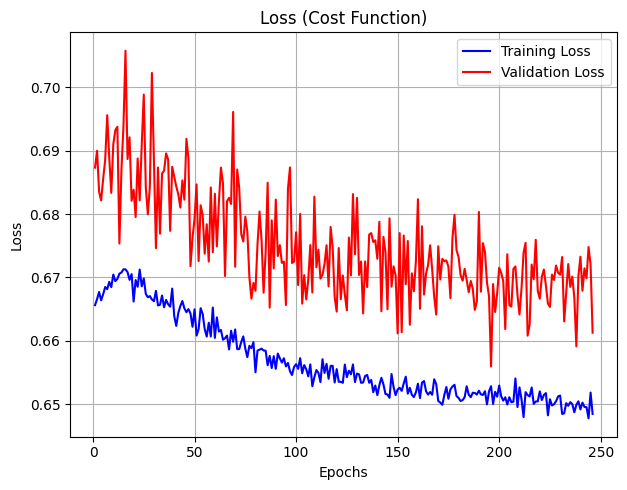

In [6]:
train_loss = history.history['loss'][3:]
val_loss = history.history['val_loss'][3:]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss (Cost Function)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Max f1 score = 0.6701570680628273
threshold for max f1 score = 0.6326326326326326
Max acc score = 0.6733780760626398
threshold for max acc score = 0.5145145145145145


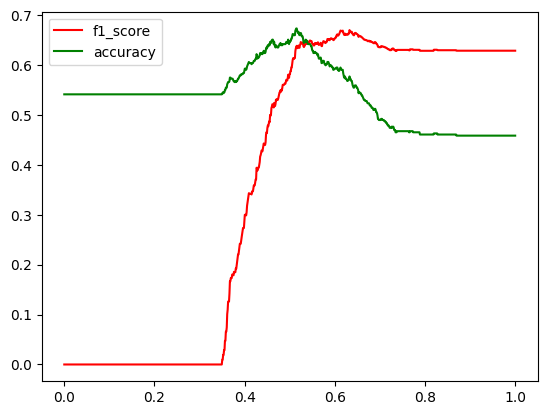

In [28]:
result = tf.sigmoid(model.predict(X_cv))
result=np.array(result).flatten()
thresholds = np.linspace(0,1, num=1000)
f1_values = []
acc_values = []
max_f1 = 0
best_thresh_f1 = 0
max_acc = 0
best_thresh_acc = 0

for thresh in thresholds:
    ypred = np.where(result > thresh, 1, 0)
    f1 = f1_score(y_cv, ypred,pos_label= 0)
    acc = accuracy_score(y_cv,ypred)
    if f1 > max_f1:
        max_f1 = f1
        best_thresh_f1 = thresh
    if acc > max_acc:
        max_acc = acc
        best_thresh_acc = thresh
    f1_values.append(f1)
    acc_values.append(acc)

plt.plot(thresholds, np.array(f1_values),color= "r", label= "f1_score")
plt.plot(thresholds, np.array(acc_values),color= "g", label= "accuracy")
plt.legend()

print(f"Max f1 score = {max_f1}")
print(f"threshold for max f1 score = {best_thresh_f1}")
print(f"Max acc score = {max_acc}")
print(f"threshold for max acc score = {best_thresh_acc}")

In [26]:
accuracy_score(y_test, np.where(np.array(tf.sigmoid(model.predict(X_test))).flatten() > 0.5, 1,0))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


0.6513761467889908

In [29]:
model.save("models/nn_raw_output.keras")